In [1]:
#!pip install numba

In [1]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [2]:
import tensorflow.keras as K
import tensorflow as tf
import time
import os
import copy
import csv
import pandas as pd
from datetime import datetime

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import datasets,models,layers

In [4]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend

In [5]:
def conv2d_bn(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same',
                   use_bias=False,
                   kernel_regularizer=l2(weight_decay)
                   )(x)
    layer = BatchNormalization()(layer)
    return layer


def conv2d_bn_relu(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = conv2d_bn(x, filters, kernel_size, weight_decay, strides)
    layer = Activation('relu')(layer)
    return layer


def ResidualBlock(x, filters, kernel_size, weight_decay, downsample=True):
    if downsample:
        # residual_x = conv2d_bn_relu(x, filters, kernel_size=1, strides=2)
        residual_x = conv2d_bn(x, filters, kernel_size=1, strides=2)
        stride = 2
    else:
        residual_x = x
        stride = 1
    residual = conv2d_bn_relu(x,
                              filters=filters,
                              kernel_size=kernel_size,
                              weight_decay=weight_decay,
                              strides=stride,
                              )
    residual = conv2d_bn(residual,
                         filters=filters,
                         kernel_size=kernel_size,
                         weight_decay=weight_decay,
                         strides=1,
                         )
    out = layers.add([residual_x, residual])
    out = Activation('relu')(out)
    return out


def ResNet18(classes, input_shape, weight_decay=1e-4):
    input = Input(shape=input_shape)
    x = input
    # x = conv2d_bn_relu(x, filters=64, kernel_size=(7, 7), weight_decay=weight_decay, strides=(2, 2))
    # x = MaxPool2D(pool_size=(3, 3), strides=(2, 2),  padding='same')(x)
    x = conv2d_bn_relu(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, strides=(1, 1))

    # # conv 2
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 3
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 4
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 5
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = AveragePooling2D(pool_size=(4, 4), padding='valid')(x)
    x = Flatten()(x)
    x = Dense(classes, activation='softmax')(x)
    model = Model(input, x, name='ResNet18')
    return model


def ResNetForCIFAR10(classes, name, input_shape, block_layers_num, weight_decay):
    input = Input(shape=input_shape)
    x = input
    x = conv2d_bn_relu(x, filters=16, kernel_size=(3, 3), weight_decay=weight_decay, strides=(1, 1))

    # # conv 2
    for i in range(block_layers_num):
        x = ResidualBlock(x, filters=16, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 3
    x = ResidualBlock(x, filters=32, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    for i in range(block_layers_num - 1):
        x = ResidualBlock(x, filters=32, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 4
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    for i in range(block_layers_num - 1):
        x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = AveragePooling2D(pool_size=(8, 8), padding='valid')(x)
    x = Flatten()(x)
    x = Dense(classes, activation='softmax')(x)
    model = Model(input, x, name=name)
    return model


def ResNet20ForCIFAR10(classes, input_shape, weight_decay):
    return ResNetForCIFAR10(classes, 'resnet20', input_shape, 3, weight_decay)


def ResNet32ForCIFAR10(classes, input_shape, weight_decay):
    return ResNetForCIFAR10(classes, 'resnet32', input_shape, 5, weight_decay)


def ResNet56ForCIFAR10(classes, input_shape, weight_decay):
    return ResNetForCIFAR10(classes, 'resnet56', input_shape, 9, weight_decay)

In [6]:
import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
#import cv2

class CIFAR10Data(object):
    def __init__(self):
        (self.x_train, self.y_train), (self.x_test, self.y_test) = cifar10.load_data()
        self.classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        print('CIFAR10 Training data shape:', self.x_train.shape)
        print('CIFAR10 Training label shape', self.y_train.shape)
        print('CIFAR10 Test data shape', self.x_test.shape)
        print('CIFAR10 Test label shape', self.y_test.shape)

    def get_stretch_data(self, subtract_mean=True):
        """
        reshape X each image to row vector, and transform Y to one_hot label.
        :param subtract_mean:Indicate whether subtract mean image.
        :return: x_train, one_hot_y_train, x_test, one_hot_y_test
        """
        num_classes = len(self.classes)
        # x_train = np.reshape(self.x_train, (self.x_train.shape[0], -1)).astype('float64')
        x_train = np.reshape(self.x_train, (self.x_train.shape[0], -1)).astype('float16')
        y_train = keras.utils.to_categorical(self.y_train, num_classes)

        # x_test = np.reshape(self.x_test, (self.x_test.shape[0], -1)).astype('float64')
        x_test = np.reshape(self.x_test, (self.x_test.shape[0], -1)).astype('float16')
        y_test = keras.utils.to_categorical(self.y_test, num_classes)

        if subtract_mean:
            mean_image = np.mean(x_train, axis=0).astype('uint8')
            x_train -= mean_image
            x_test -= mean_image
            # print(x_mean[:10])
            # plt.figure(figsize=(4, 4))
            # plt.imshow(x_mean.reshape((32, 32, 3)))
            # plt.show()

        return x_train, y_train, x_test, y_test

    def get_data(self, subtract_mean=True, output_shape=None):
        """
        The data is not reshaped, keep 3 channel.
        :param subtract_mean:Indicate whether subtract mean image.
        :param output_shape:Indicate whether resize image
        :return: x_train, one_hot_y_train, x_test, one_hot_y_test
        """
        num_classes = len(self.classes)
        x_train = self.x_train
        x_test = self.x_test
        # if output_shape:resize
        #     x_train = np.array([cv2.resize(img, output_shape) for img in self.x_train])
        #     x_test = np.array([cv2.(img, output_shape) for img in self.x_test])

        x_train = x_train.astype('float16')
        y_train = keras.utils.to_categorical(self.y_train, num_classes)

        x_test = x_test.astype('float16')
        y_test = keras.utils.to_categorical(self.y_test, num_classes)

        if subtract_mean:
            mean_image = np.mean(x_train, axis=0)
            x_train -= mean_image
            x_test -= mean_image
        return x_train, y_train, x_test, y_test


def plot_cifar10(cifar_data, num_sample_per_class):
    """
    random select num_sample_per_class to plot
    """
    num_classes = len(cifar_data.classes)

    plt.figure()
    for y, cls in enumerate(cifar_data.classes):
        cls_indices = np.flatnonzero(cifar_data.y_train == y)
        samples_indices = np.random.choice(cls_indices, num_sample_per_class, replace=False)
        samples = cifar_data.x_train[samples_indices]
        for x, sample in enumerate(samples):
            # subplot index count from 1
            plt_idx = x * num_classes + y + 1
            plt.subplot(num_sample_per_class, num_classes, plt_idx)
            plt.imshow(sample)
            plt.axis('off')
            if x == 0:
                plt.title(cls)
    plt.show()

In [7]:
# get data
cifar10_data = CIFAR10Data()
x_train, y_train, x_test, y_test = cifar10_data.get_data(subtract_mean=True)

num_train = int(x_train.shape[0] * 0.8)
num_val = x_train.shape[0] - num_train
mask = list(range(num_train, num_train+num_val))
x_val = x_train[mask]
y_val = y_train[mask]

mask = list(range(num_train))
x_train = x_train[mask]
y_train = y_train[mask]
data = (x_train, y_train, x_val, y_val, x_test, y_test)

CIFAR10 Training data shape: (50000, 32, 32, 3)
CIFAR10 Training label shape (50000, 1)
CIFAR10 Test data shape (10000, 32, 32, 3)
CIFAR10 Test label shape (10000, 1)


In [8]:
#from classifiers.ResNet import ResNet18
from tensorflow.keras import losses
from tensorflow.keras import optimizers

weight_decay = 1e-4
lr = 0.001 # 1e-1
num_classes = 10
resnet18 = ResNet18(input_shape=(32, 32, 3), classes=num_classes, weight_decay=weight_decay)
opt = optimizers.SGD(lr=lr, momentum=0.9, nesterov=False)
resnet18.compile(optimizer=opt,
                 loss=losses.categorical_crossentropy,
                 metrics=['accuracy'])
resnet18.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K


def plot_history(history):
    """
    plot train epoch history and acc
    :param history: train history object returned by CIFAR10Solver.train()
    """
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('Loss value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


class CIFAR10Solver(object):
    """
    A CIFAR10Solver encapsulates all the logic nessary for training cifar10 classifiers.The train model is defined
    outside, you must pass it to init().
    The solver train the model, plot loss and aac history, and test on the test data.
    Example usage might look something like this.
    model = MyAwesomeModel(opt=SGD, losses='categorical_crossentropy',  metrics=['acc'])
    model.compile(...)
    model.summary()
    solver = CIFAR10Solver(model)
    history = solver.train()
    plotHistory(history)
    solver.test()
    """

    def __init__(self, model, data):
        """
        :param model: A model object conforming to the API described above
        :param data:  A tuple of training, validation and test data from CIFAR10Data
        """
        self.model = model
        self.X_train, self.Y_train, self.X_val, self.Y_val, self.X_test, self.Y_test = data

    def __on_epoch_end(self, epoch, logs=None):
        print(K.eval(self.model.optimizer.lr))

    def train(self, epochs=200, batch_size=128, data_augmentation=True, callbacks=None):
        if data_augmentation:
            # datagen
            datagen = ImageDataGenerator(
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                # rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=4,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=4,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False,  # randomly flip images
            )
            # (std, mean, and principal components if ZCA whitening is applied).
            # datagen.fit(x_train)
            print('train with data augmentation')
            train_gen = datagen.flow(self.X_train, self.Y_train, batch_size=batch_size)
            history = self.model.fit_generator(generator=train_gen,
                                               epochs=epochs,
                                               callbacks=callbacks,
                                               validation_data=(self.X_val, self.Y_val),
                                               )
        else:
            print('train without data augmentation')
            history = self.model.fit(self.X_train, self.Y_train,
                                     batch_size=batch_size, epochs=epochs,
                                     callbacks=callbacks,
                                     validation_data=(self.X_val, self.Y_val),
                                     )
        return history

    def test(self):
        loss, acc = self.model.evaluate(self.X_test, self.Y_test)
        print('test data loss:%.2f acc:%.4f' % (loss, acc))

In [10]:
model_name = 'resnet18-cifar10'
training_round = 10

In [11]:
date = datetime.today().strftime('%Y-%m-%d')
check_point = tf.keras.callbacks.ModelCheckpoint(filepath="./data/26-10-2021/Train1/Keras/resnet18/tf_{}_{}_{}.h5".format(model_name,date, training_round),
                                              monitor="val_acc",
                                              mode="max",
                                              save_best_only=True,
                                              )

In [12]:
%%time
#from cifar10_solver import *
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch):
    new_lr = lr * (0.1 ** (epoch // 50))
    print('new lr:%.2e' % new_lr)
    return new_lr 

reduce_lr = LearningRateScheduler(lr_scheduler)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                               patience=10, min_lr=1e-6, verbose=1)

solver = CIFAR10Solver(resnet18, data)
history = solver.train(epochs=50, batch_size=128, data_augmentation=False, callbacks=[check_point])

train without data augmentation
Epoch 1/50
313/313 [==============================] - 24s 57ms/step - loss: 2.2434 - accuracy: 0.3182 - val_loss: 1.8067 - val_accuracy: 0.4765
Epoch 2/50
313/313 [==============================] - 16s 52ms/step - loss: 1.6149 - accuracy: 0.5460 - val_loss: 1.6238 - val_accuracy: 0.5363
Epoch 3/50
313/313 [==============================] - 16s 53ms/step - loss: 1.3707 - accuracy: 0.6403 - val_loss: 1.4467 - val_accuracy: 0.6075
Epoch 4/50
313/313 [==============================] - 16s 53ms/step - loss: 1.1804 - accuracy: 0.7162 - val_loss: 1.4309 - val_accuracy: 0.6314
Epoch 5/50
313/313 [==============================] - 17s 53ms/step - loss: 1.0010 - accuracy: 0.7876 - val_loss: 1.4420 - val_accuracy: 0.6300
Epoch 6/50
313/313 [==============================] - 17s 53ms/step - loss: 0.8276 - accuracy: 0.8540 - val_loss: 1.4686 - val_accuracy: 0.6356
Epoch 7/50
313/313 [==============================] - 17s 53ms/step - loss: 0.6625 - accuracy: 0.9149 - 

Epoch 38/50
313/313 [==============================] - 17s 55ms/step - loss: 0.3412 - accuracy: 1.0000 - val_loss: 1.8879 - val_accuracy: 0.6747
Epoch 39/50
313/313 [==============================] - 17s 55ms/step - loss: 0.3407 - accuracy: 1.0000 - val_loss: 1.8893 - val_accuracy: 0.6731
Epoch 40/50
313/313 [==============================] - 17s 54ms/step - loss: 0.3403 - accuracy: 1.0000 - val_loss: 1.9028 - val_accuracy: 0.6739
Epoch 41/50
313/313 [==============================] - 17s 55ms/step - loss: 0.3399 - accuracy: 1.0000 - val_loss: 1.9021 - val_accuracy: 0.6762
Epoch 42/50
313/313 [==============================] - 17s 55ms/step - loss: 0.3395 - accuracy: 1.0000 - val_loss: 1.9075 - val_accuracy: 0.6753
Epoch 43/50
313/313 [==============================] - 17s 55ms/step - loss: 0.3389 - accuracy: 1.0000 - val_loss: 1.9073 - val_accuracy: 0.6754
Epoch 44/50
313/313 [==============================] - 17s 55ms/step - loss: 0.3385 - accuracy: 1.0000 - val_loss: 1.9113 - val_ac

In [13]:
solver.model.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

### Lets visualized what happened first

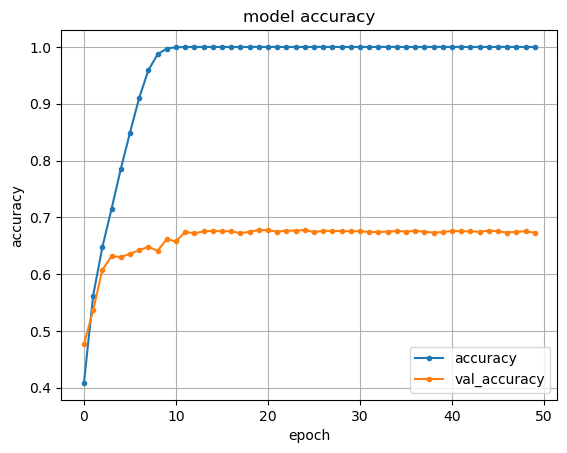

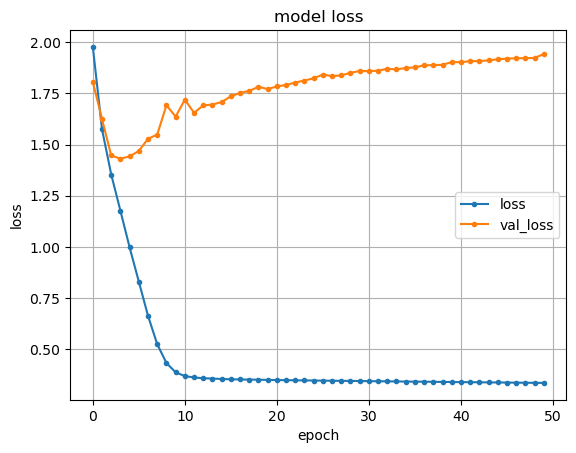

In [14]:
from matplotlib import pyplot as plt


plt.plot(history.history['accuracy'], marker='.', label='accuracy')
plt.plot(history.history['val_accuracy'], marker='.', label='val_accuracy')
plt.title('model accuracy')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()


plt.plot(history.history['loss'], marker='.', label='loss')
plt.plot(history.history['val_loss'], marker='.', label='val_loss')
plt.title('model loss')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

In [15]:
date = datetime.today().strftime('%Y-%m-%d')
solver.model.save("./data/26-10-2021/Train1/Keras/resnet18/tf_{}_{}_{}.h5".format(model_name,date, training_round))

In [16]:
def export_history_csv(history_, model_name):
    since = time.time()
    data_file = open('./data/26-10-2021/Train1/Keras/resnet18/tf_{}_{}_{}.csv'.format(model_name,date, training_round), mode='w+', newline='', encoding='utf-8')
    data_writer = csv.writer(data_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    data_writer.writerow(['Model','type', 'Dataset', 'Epoch', 'criterion', 'optimizer', 'scheduler','Train_loss', 'Train_acc', "val_loss", "Val_acc", 'time','Elapse_time','date'])
    for epoch_ in history_.epoch: 
        data_writer.writerow([history_.model,'tensorflow', 'hymenoptera', epoch_, '', 
                          history_.model.optimizer, '',history_.history['loss'][epoch_], history_.history['accuracy'][epoch_], 
                          history_.history['val_loss'][epoch_], history_.history['val_accuracy'][epoch_], '','',date])
    data_file.close()

In [17]:

export_history_csv(history, model_name)

In [18]:
# plot loss and acc 
#plot_history(history)

# Lets train VGG on the similar dataset

In [19]:
model_name = 'vgg-cifar10'

In [20]:
from tensorflow.keras.models import Model
#from tensorflow.keras.models import Input
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras import regularizers


def conv2d_bn_relu(model,
                   filters,
                   block_index, layer_index,
                   weight_decay=.0, padding='same'):
    conv_name = 'conv' + str(block_index) + '-' + str(layer_index)
    model = Conv2D(filters=filters,
                   kernel_size=(3, 3),
                   padding=padding,
                   kernel_regularizer=regularizers.l2(weight_decay),
                   strides=(1, 1),
                   name=conv_name,
                   )(model)
    bn_name = 'bn' + str(block_index) + '-' + str(layer_index)
    model = BatchNormalization(name=bn_name)(model)
    relu_name = 'relu' + str(block_index) + '-' + str(layer_index)
    model = Activation('relu', name=relu_name)(model)
    return model


def dense2d_bn_dropout(model, units, weight_decay, name):
    model = Dense(units,
                  kernel_regularizer=regularizers.l2(weight_decay),
                  name=name,
                  )(model)
    model = BatchNormalization(name=name + '-bn')(model)
    model = Activation('relu', name=name + '-relu')(model)
    model = Dropout(0.5, name=name + '-dropout')(model)
    return model


def VGGNet(classes, input_shape, weight_decay,
           conv_block_num=5,
           fc_layers=2, fc_units=4096):
    input = Input(shape=input_shape)
    # block 1
    x = conv2d_bn_relu(model=input,
                       filters=64,
                       block_index=1, layer_index=1,
                       weight_decay=weight_decay
                       )
    x = conv2d_bn_relu(model=x,
                       filters=64,
                       block_index=1, layer_index=2,
                       weight_decay=weight_decay)
    x = MaxPool2D(name='pool1')(x)

    # block 2
    if conv_block_num >= 2:
        x = conv2d_bn_relu(x,
                           filters=128,
                           block_index=2, layer_index=1,
                           weight_decay=weight_decay)
        x = conv2d_bn_relu(x,
                           filters=128,
                           block_index=2, layer_index=2,
                           weight_decay=weight_decay)
        x = MaxPool2D(name='pool2')(x)

    # block 3
    if conv_block_num >= 3:
        x = conv2d_bn_relu(x,
                           filters=256,
                           block_index=3, layer_index=1,
                           weight_decay=weight_decay)
        x = conv2d_bn_relu(x,
                           filters=256,
                           block_index=3, layer_index=2,
                           weight_decay=weight_decay)
        x = conv2d_bn_relu(x,
                           filters=256,
                           block_index=3, layer_index=3,
                           weight_decay=weight_decay)
        x = MaxPool2D(name='pool3')(x)

    # block 4
    if conv_block_num >= 4:
        x = conv2d_bn_relu(x,
                           filters=512,
                           block_index=4, layer_index=1,
                           weight_decay=weight_decay)
        x = conv2d_bn_relu(x,
                           filters=512,
                           block_index=4, layer_index=2,
                           weight_decay=weight_decay)
        x = conv2d_bn_relu(x,
                           filters=512,
                           block_index=4, layer_index=3,
                           weight_decay=weight_decay)
        x = MaxPool2D(name='pool4')(x)

    # block 5
    if conv_block_num >= 5:
        x = conv2d_bn_relu(x,
                           filters=512,
                           block_index=5, layer_index=1,
                           weight_decay=weight_decay)
        x = conv2d_bn_relu(x,
                           filters=512,
                           block_index=5, layer_index=2,
                           weight_decay=weight_decay)
        x = conv2d_bn_relu(x,
                           filters=512,
                           block_index=5, layer_index=3,
                           weight_decay=weight_decay)
        x = MaxPool2D(name='pool5')(x)

    x = Flatten(name='flatten')(x)
    if fc_layers >= 1:
        x = dense2d_bn_dropout(x, fc_units, weight_decay, 'fc6')
        if fc_layers >= 2:
            x = dense2d_bn_dropout(x, fc_units, weight_decay, 'fc7')
    out = Dense(classes, activation='softmax', name='predictions')(x)
    model = Model(input, out)
    return model


def VGG13(classes):
    return VGGNet(classes, weight_decay=1e-4, conv_block_num=4, fc_layers=2, fc_units=4096)


def VGG16(classes):
    return VGGNet(classes, weight_decay=1e-4, conv_block_num=5, fc_layers=2, fc_units=4096)

In [21]:
# get data
cifar10_data = CIFAR10Data()
x_train, y_train, x_test, y_test = cifar10_data.get_data(subtract_mean=True)

num_train = int(x_train.shape[0] * 0.8)
num_val = x_train.shape[0] - num_train
mask = list(range(num_train, num_train+num_val))
x_val = x_train[mask]
y_val = y_train[mask]

mask = list(range(num_train))
x_train = x_train[mask]
y_train = y_train[mask]
print(x_train.shape)

CIFAR10 Training data shape: (50000, 32, 32, 3)
CIFAR10 Training label shape (50000, 1)
CIFAR10 Test data shape (10000, 32, 32, 3)
CIFAR10 Test label shape (10000, 1)
(40000, 32, 32, 3)


In [22]:
weight_decay = 5e-4
#lr = 1e-1
num_classes = 10

vgg = VGGNet(classes=num_classes, 
             input_shape=x_train.shape[1:], 
             weight_decay=weight_decay, 
             conv_block_num=4,
             fc_layers=2,
             fc_units=512
             ) 

# sgd
opt = keras.optimizers.SGD(lr=lr, momentum=0.9, nesterov=False)
vgg.compile(loss='categorical_crossentropy', 
            optimizer=opt, 
            metrics=['accuracy'])
vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv1-1 (Conv2D)             (None, 32, 32, 64)        1792      
_________________________________________________________________
bn1-1 (BatchNormalization)   (None, 32, 32, 64)        256       
_________________________________________________________________
relu1-1 (Activation)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv1-2 (Conv2D)             (None, 32, 32, 64)        36928     
_________________________________________________________________
bn1-2 (BatchNormalization)   (None, 32, 32, 64)        256       
_________________________________________________________________
relu1-2 (Activation)         (None, 32, 32, 64)        0     

In [23]:
check_point = tf.keras.callbacks.ModelCheckpoint(filepath="./data/26-10-2021/Train1/Keras/vgg/tf_{}_{}_{}.h5".format(model_name,date, training_round),
                                              monitor="val_acc",
                                              mode="max",
                                              save_best_only=True,
                                              )

In [24]:
%%time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
# fit data with data augmentation or not
data_augmentation = False


def lr_scheduler(epoch):
    return lr * (0.1 ** (epoch // 50))

reduce_lr = LearningRateScheduler(lr_scheduler)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                               patience=10, min_lr=1e-6, verbose=1)

batch_size = 128
epochs = 50

if data_augmentation:
    # datagen
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False, # randomly flip images
    ) 
    # (std, mean, and principal components if ZCA whitening is applied).
    # datagen.fit(x_train)
    print('train with data augmentation')
    history = vgg.fit_generator(generator=datagen.flow(x_train, y_train, batch_size=batch_size),
                                epochs=epochs,
                                callbacks=[reduce_lr],
                                validation_data=(x_val, y_val)
                                )
else:
    print('train without data augmentation')
    history = vgg.fit(x_train, y_train, 
                      batch_size=batch_size, epochs=epochs, 
                      callbacks=[check_point],
                      validation_data=(x_val, y_val)
                      )

train without data augmentation
Epoch 1/50
313/313 [==============================] - 13s 33ms/step - loss: 4.1516 - accuracy: 0.2387 - val_loss: 3.4932 - val_accuracy: 0.3879
Epoch 2/50
313/313 [==============================] - 9s 30ms/step - loss: 3.3133 - accuracy: 0.4681 - val_loss: 2.9997 - val_accuracy: 0.5800
Epoch 3/50
313/313 [==============================] - 9s 29ms/step - loss: 3.0112 - accuracy: 0.5715 - val_loss: 2.9222 - val_accuracy: 0.6051
Epoch 4/50
313/313 [==============================] - 9s 29ms/step - loss: 2.8164 - accuracy: 0.6410 - val_loss: 2.7612 - val_accuracy: 0.6596
Epoch 5/50
313/313 [==============================] - 9s 29ms/step - loss: 2.6641 - accuracy: 0.6945 - val_loss: 2.6487 - val_accuracy: 0.7038
Epoch 6/50
313/313 [==============================] - 9s 29ms/step - loss: 2.5220 - accuracy: 0.7409 - val_loss: 2.6310 - val_accuracy: 0.7024
Epoch 7/50
313/313 [==============================] - 9s 29ms/step - loss: 2.4090 - accuracy: 0.7789 - val_lo

Epoch 38/50
313/313 [==============================] - 9s 30ms/step - loss: 1.4848 - accuracy: 0.9992 - val_loss: 2.5599 - val_accuracy: 0.7703
Epoch 39/50
313/313 [==============================] - 9s 30ms/step - loss: 1.4735 - accuracy: 0.9997 - val_loss: 2.5671 - val_accuracy: 0.7718
Epoch 40/50
313/313 [==============================] - 9s 30ms/step - loss: 1.4649 - accuracy: 0.9994 - val_loss: 2.5340 - val_accuracy: 0.7699
Epoch 41/50
313/313 [==============================] - 9s 30ms/step - loss: 1.4551 - accuracy: 0.9996 - val_loss: 2.5853 - val_accuracy: 0.7592
Epoch 42/50
313/313 [==============================] - 9s 30ms/step - loss: 1.4501 - accuracy: 0.9984 - val_loss: 2.5473 - val_accuracy: 0.7656
Epoch 43/50
313/313 [==============================] - 9s 30ms/step - loss: 1.4373 - accuracy: 0.9996 - val_loss: 2.5160 - val_accuracy: 0.7706
Epoch 44/50
313/313 [==============================] - 9s 30ms/step - loss: 1.4285 - accuracy: 0.9995 - val_loss: 2.5072 - val_accuracy:

In [25]:
def export_history_csv(history_, model_name):
    since = time.time()
    data_file = open('./data/26-10-2021/Train1/Keras/vgg/tf_{}_{}_{}.csv'.format(model_name,date, training_round), mode='w+', newline='', encoding='utf-8')
    data_writer = csv.writer(data_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    data_writer.writerow(['Model','type', 'Dataset', 'Epoch', 'criterion', 'optimizer', 'scheduler','Train_loss', 'Train_acc', "val_loss", "Val_acc", 'time','Elapse_time','date'])
    for epoch_ in history_.epoch: 
        data_writer.writerow([history_.model,'tensorflow', 'hymenoptera', epoch_, '', 
                          history_.model.optimizer, '',history_.history['loss'][epoch_], history_.history['accuracy'][epoch_], 
                          history_.history['val_loss'][epoch_], history_.history['val_accuracy'][epoch_], '','',date])
    data_file.close()

In [26]:
export_history_csv(history, model_name)

In [27]:
vgg.save("./data/26-10-2021/Train1/Keras/vgg/tf_{}_{}_{}.h5".format(model_name,date, training_round))

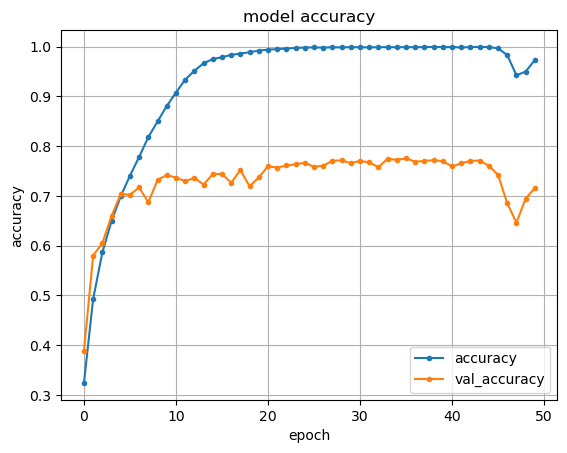

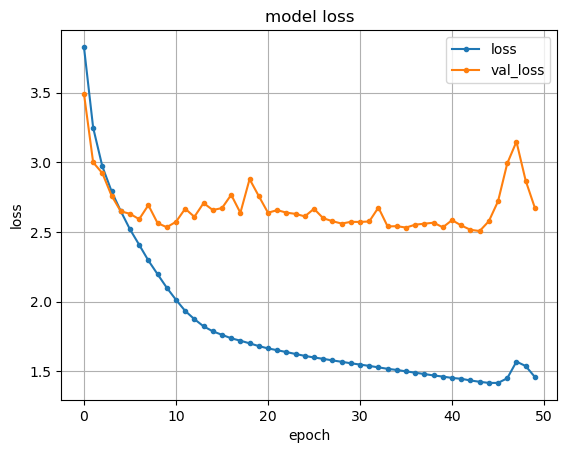

In [28]:
from matplotlib import pyplot as plt


plt.plot(history.history['accuracy'], marker='.', label='accuracy')
plt.plot(history.history['val_accuracy'], marker='.', label='val_accuracy')
plt.title('model accuracy')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()


plt.plot(history.history['loss'], marker='.', label='loss')
plt.plot(history.history['val_loss'], marker='.', label='val_loss')
plt.title('model loss')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()